# [LLM Classification Finetuning](https://www.kaggle.com/competitions/llm-classification-finetuning/overview)
Finetune LLMs to Predict Human Preference using Chatbot Arena conversations

(notebookf690519948)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/config.json
/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/merges.txt
/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/tokenizer.json
/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/vocab.json
/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/tokenizer_config.json
/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/model.safetensors
/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model/special_tokens_map.json
/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv
/kaggle/input/distilbert-finetuned/transformers/default/1/kaggle/working/my-finetuned-model/config.json
/kaggle/input/distilbert-finetuned/transformers/default/1/kaggle/working/my-finetuned-model/merges.txt
/kaggle/in

# Reading data

In [2]:
train_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

In [3]:
train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [4]:
test_df.head()

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [5]:
pd.read_csv('/kaggle/input/llm-classification-finetuning/sample_submission.csv').head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


# Exploration

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [7]:
train_df['response_a_word_len'] = train_df['response_a'].map(lambda x: len(x.split()))
train_df['response_b_word_len'] = train_df['response_b'].map(lambda x: len(x.split()))

In [8]:
train_df[['winner_model_a',	'winner_model_b', 'winner_tie',	'response_a_word_len', 'response_b_word_len']].head()

,winner_model_a,winner_model_b,winner_tie,response_a_word_len,response_b_word_len
0,1,0,0,656,204
1,0,1,0,531,571
2,0,0,1,138,280
3,1,0,0,536,265
4,0,1,0,230,122


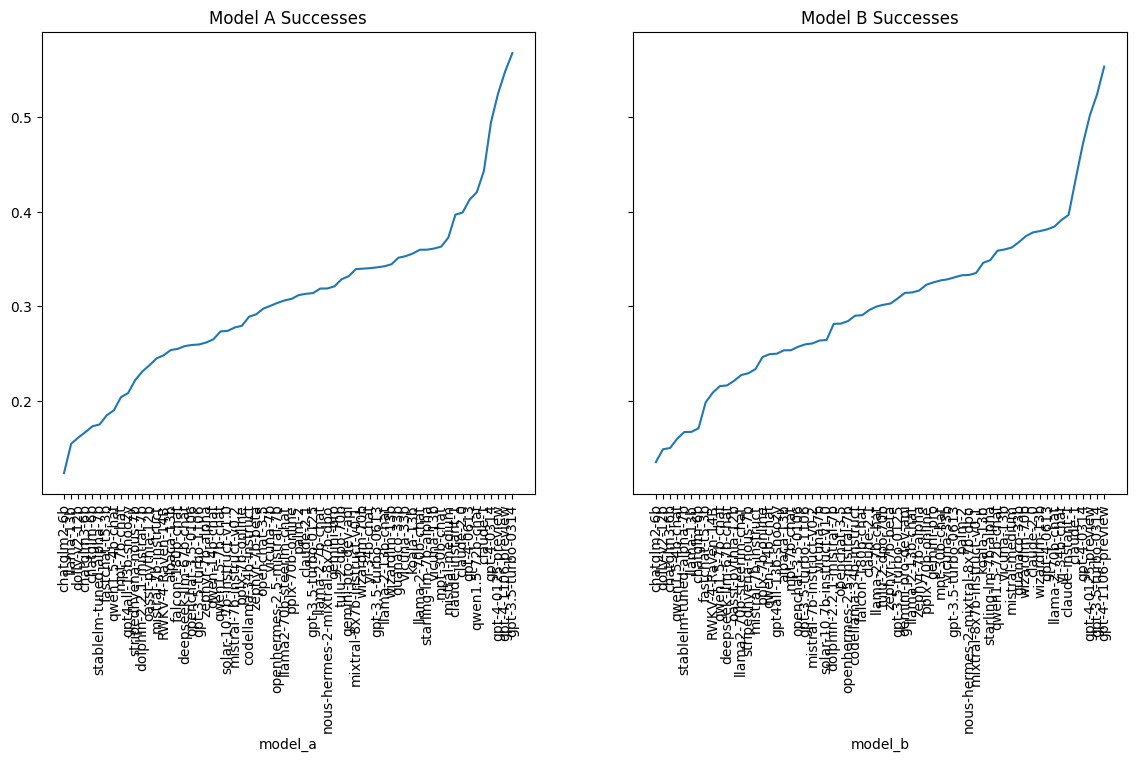

In [9]:
model_a_successes = train_df[['model_a', 'winner_model_a']].groupby('model_a').mean().sort_values(by='winner_model_a')
model_b_successes = train_df[['model_b', 'winner_model_b']].groupby('model_b').mean().sort_values(by='winner_model_b')
# ax = model_a_successes.plot()


fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot A
model_a_successes.plot(ax=axes[0], legend=False, title="Model A Successes")
axes[0].set_xticks(range(len(model_a_successes)))
axes[0].set_xticklabels(model_a_successes.index, rotation=90)

# Plot B
model_b_successes.plot(ax=axes[1], legend=False, title="Model B Successes")
axes[1].set_xticks(range(len(model_b_successes)))
axes[1].set_xticklabels(model_b_successes.index, rotation=90)

plt.show()

# Finetuning

In [10]:
# !transformers-cli download distilbert-base-uncased

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

2025-09-05 15:16:47.453896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757085407.820521      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757085407.923947      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
# # uncomment during training (along with the remaining commented code in this section)
# model_name = "distilroberta-base"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [13]:
def preprocess_and_label(batch, label=True):
    # Build text inputs
    texts = [
        f"Prompt: {p}\nResponse A: {a}\nResponse B: {b}"
        for p, a, b in zip(batch["prompt"], batch["response_a"], batch["response_b"])
    ]

    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=512)

    if label:
        # Add labels
        labels = []
        for a, b in zip(batch["winner_model_a"], batch["winner_model_b"]):
            if a == 1:
                labels.append(0)
            elif b == 1:
                labels.append(1)
            else:
                labels.append(2)
    
        encodings["labels"] = labels
    return encodings

In [14]:
# dataset = load_dataset("csv", data_files='/kaggle/input/llm-classification-finetuning/train.csv')
# dataset = dataset.map(preprocess_and_label, batched=True, num_proc=8)

In [15]:
# train_test = dataset["train"].train_test_split(test_size=0.1, seed=42)
# dataset = DatasetDict({
#     "train": train_test["train"],
#     "test": train_test["test"]
# })

# dataset["train"].features

In [16]:
# data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# training_args = TrainingArguments(
#     output_dir="./results",
#     per_device_train_batch_size=8,
#     num_train_epochs=3,                # start small to test
#     logging_strategy="steps",          # log by steps, not just epoch
#     logging_steps=50,                  # log every 50 steps
#     eval_strategy="steps",       # run eval every few steps
#     eval_steps=800,                    # how often to evaluate
#     save_strategy="steps",             # ✅ don’t save checkpoints during training
#     save_steps=800,
#     load_best_model_at_end=True,
#     report_to="none"                   # disable wandb/tensorboard unless you want them
# )

In [17]:
# !pip install evaluate

In [18]:
# import evaluate

# accuracy = evaluate.load("accuracy")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     preds = logits.argmax(axis=-1)
#     return accuracy.compute(predictions=preds, references=labels)

In [19]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=dataset["train"],
#     eval_dataset=dataset["test"],
#     data_collator=data_collator,
#     processing_class=tokenizer,
#     compute_metrics=compute_metrics,  # ✅ metrics hook
# )

In [20]:
# trainer.train()

In [21]:
# metrics = trainer.evaluate()
# print(metrics)

In [22]:
# model.save_pretrained("/kaggle/working/my-finetuned-model")
# tokenizer.save_pretrained("/kaggle/working/my-finetuned-model")

In [23]:
# !ls -R /kaggle/working/my-finetuned-model

In [24]:
# !zip -r /kaggle/working/my-finetuned-model.zip /kaggle/working/my-finetuned-model

In [25]:
!ls /kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model

config.json  model.safetensors	      tokenizer_config.json  vocab.json
merges.txt   special_tokens_map.json  tokenizer.json


Download the zipped model from output by hand and add in Input > datasets

# Inference

In [26]:
# !unzip -q /kaggle/input/my-finetuned-model/my-finetuned-model.zip -d /kaggle/working/

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model", 
    local_files_only=True
)

tokenizer = AutoTokenizer.from_pretrained(
    "/kaggle/input/distilbert-finetuned-1/kaggle/working/my-finetuned-model", 
    local_files_only=True
)

dataset = load_dataset("csv", data_files='/kaggle/input/llm-classification-finetuning/train.csv')
dataset = dataset.map(preprocess_and_label, batched=True, num_proc=8)
train_test = dataset["train"].train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({"train": train_test["train"], "test": train_test["test"]})

# ideally we would use pipeline instead of redefining all this
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="/kaggle/temp",
    per_device_train_batch_size=8,
    num_train_epochs=3,                # start small to test
    logging_strategy="steps",          # log by steps, not just epoch
    logging_steps=50,                  # log every 50 steps
    eval_strategy="steps",       # run eval every few steps
    eval_steps=800,                    # how often to evaluate
    save_strategy="steps",             # ✅ don’t save checkpoints during training
    save_steps=800,
    load_best_model_at_end=True,
    report_to="none"                   # disable wandb/tensorboard unless you want them
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,  # ✅ metrics hook
)

Generating train split: 0 examples [00:00, ? examples/s]

Map (num_proc=8):   0%|          | 0/57477 [00:00<?, ? examples/s]

In [28]:
test_dataset = load_dataset("csv", data_files='/kaggle/input/llm-classification-finetuning/test.csv')
preprocess = lambda x: preprocess_and_label(x, label=False)
test_dataset = test_dataset.map(preprocess, batched=True, num_proc=8)

Generating train split: 0 examples [00:00, ? examples/s]

num_proc must be <= 3. Reducing num_proc to 3 for dataset of size 3.


Map (num_proc=3):   0%|          | 0/3 [00:00<?, ? examples/s]

In [29]:
predictions = trainer.predict(test_dataset["train"])
logits = predictions.predictions
preds = F.softmax(torch.from_numpy(logits), dim=-1)
preds

tensor([[0.2949, 0.3060, 0.3990],
        [0.3078, 0.3188, 0.3734],
        [0.3815, 0.3700, 0.2485]])

In [30]:
submission = pd.DataFrame({
    "id": test_dataset["train"]["id"],
    "winner_model_a": preds[:, 0].numpy(),
    "winner_model_b": preds[:, 1].numpy(),
    "winner_tie": preds[:, 2].numpy()
})

submission

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.294912,0.306042,0.399046
1,211333,0.307847,0.318788,0.373365
2,1233961,0.381509,0.369959,0.248532


In [31]:
submission.to_csv("submission.csv", index=False)